In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

!git clone https://github.com/htymjun/da-sr
os.chdir('/content/da-sr')

from read import fw_to_np

Cloning into 'da-sr'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 60 (delta 31), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (60/60), 10.04 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [3]:
# read cn and fw files
u, v, w, p, t, icount, x, y, z = fw_to_np('data')
# interpolate
uc = 0.5e0*(u[:-1,:,:]+u[1:,:,:])
vc = 0.5e0*(v[:,:-1,:]+v[:,1:,:])
wc = 0.5e0*(w[:,:,:-1]+w[:,:,1:])
xc = 0.5e0*(x[:-1]+x[1:])
yc = 0.5e0*(y[:-1]+y[1:])
zc = 0.5e0*(z[:-1]+z[1:])

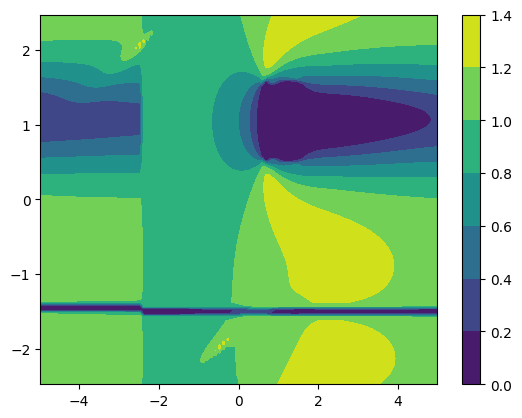

In [4]:
Nz = int(0.5*len(zc))
U = np.sqrt(uc[:,:,Nz]**2+vc[:,:,Nz]**2)
Xc, Yc = np.meshgrid(xc,yc)

fig, ax = plt.subplots()
tcf = ax.contourf(Xc, Yc, np.transpose(U))
fig.colorbar(tcf)

In [5]:
# set_batch
Nx = 10
Ny = 10
ub = uc[:,:,Nz].reshape(-1,Nx,Ny)
vb = vc[:,:,Nz].reshape(-1,Nx,Ny)
x = np.stack([ub,vb], axis=-1)
x = np.swapaxes(x, 1,3) # x[batch_size,channel,height,width]

# normalize
N = len(x[:,0,0,0]) # N : batch_size
ave = np.zeros(N)
for i in range(N):
  ave[i] = 0.5e0*(x[i,0,:,:].mean()+x[i,1,:,:].mean())
  x[i,0,:,:] = np.divide(x[i,0,:,:],ave[i])
  x[i,1,:,:] = np.divide(x[i,1,:,:],ave[i])

In [19]:
class GCNN(nn.Module):
  def __init__(self, filters):
    super(GCNN, self).__init__()
    self.filters = filters

  def rotate_filter(self, k):
    return torch.rot90(self.filters, k, dims=(2,3))

  def g_conv(self, x):
    # Z2-P4 conv
    x1 = F.conv2d(x, self.filters, stride=(1,1), padding=0)
    x2 = F.conv2d(x, self.rotate_filter(1), stride=(1,1), padding=0)
    x3 = F.conv2d(x, self.rotate_filter(2), stride=(1,1), padding=0)
    x4 = F.conv2d(x, self.rotate_filter(3), stride=(1,1), padding=0)
    '''
    # P4-P4 conv
    x1 = F.conv2d(x1, self.filters, stride=(1,1), padding=0)
    x2 = F.conv2d(x2, self.rotate_filter(1), stride=(1,1), padding=0)
    x3 = F.conv2d(x3, self.rotate_filter(2), stride=(1,1), padding=0)
    x4 = F.conv2d(x4, self.rotate_filter(3), stride=(1,1), padding=0)
    '''
    # pooling
    x1 = F.max_pool2d(x1, kernel_size=2, stride=1, padding=0)
    x2 = F.max_pool2d(x2, kernel_size=2, stride=1, padding=0)
    x3 = F.max_pool2d(x3, kernel_size=2, stride=1, padding=0)
    x4 = F.max_pool2d(x4, kernel_size=2, stride=1, padding=0)
    x = torch.max(torch.max(x1,x2),torch.max(x3,x4))
    return x

  def forward(self, x):
    x = self.g_conv(x)

    return x

In [20]:
filters = torch.randn([1, 2, 5, 5]) # filters[batch_size,input_channel,height,width]
X = torch.tensor(x)                 # x[batch_size,channel,height,width]

model = GCNN(filters=filters)
x1 = model(torch.rot90(X,dims=(2,3))) # rotate input 90 degree
x2 = model(X)

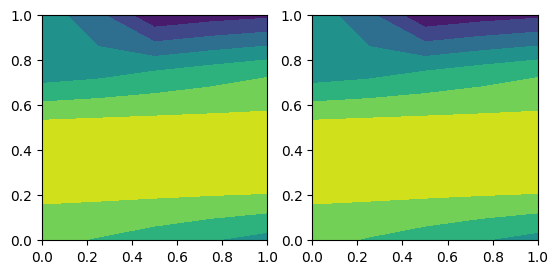

In [21]:
# visualize
Xc, Yc = np.meshgrid(np.linspace(0,1,len(x1[0,0,0,:])),np.linspace(0,1,len(x1[0,0,:,0])))

fig, axes = plt.subplots(1,2)
tcf = axes[0].contourf(Xc, Yc, x1[0,0,:,:])
axes[0].set_aspect('equal')
tcf = axes[1].contourf(Xc, Yc, np.rot90(x2[0,0,:,:],k=1)) # rotate output 90 degree
axes[1].set_aspect('equal')